<a href="https://colab.research.google.com/github/BalintKomjati/infinite-loop/blob/main/stable-diffusion-2-infinite-zoom-out/infinite_zoom_out.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@markdown Check type of GPU and VRAM available.   
#@markdown The notebook should work with the Tesla T4 GPU + 16 GB VRAM available in the free colab tier.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Tesla T4, 15360 MiB, 15109 MiB


In [1]:
#@markdown Install missing libraries
%pip install -qq transformers scipy ftfy accelerate
%pip install -qq --upgrade diffusers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 110.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 KB 10.9 MB/s eta 0:00:00


In [2]:
# load libs
import PIL
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import random
import cv2
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
from IPython.display import clear_output

In [88]:
def write_video(file_path, frames, fps, reversed = True):
    """
    Writes frames to an mp4 video file
    :param file_path: Path to output video, must end with .mp4
    :param frames: List of PIL.Image objects
    :param fps: Desired frame rate
    :param reversed: if order of images to be reversed (default = True)
    """
    if reversed == True:
      frames.reverse()

    w, h = frames[0].size
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    #fourcc = cv2.VideoWriter_fourcc(*'avc1')
    writer = cv2.VideoWriter(file_path, fourcc, fps, (w, h))

    for frame in frames:
        np_frame = np.array(frame.convert('RGB'))
        cv_frame = cv2.cvtColor(np_frame, cv2.COLOR_RGB2BGR)
        writer.write(cv_frame)

    writer.release() 

In [8]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [5]:
repo_id = "stabilityai/stable-diffusion-2-inpainting"

In [ ]:
# Download and set up diffusion pipeline
pipe = DiffusionPipeline.from_pretrained(repo_id, torch_dtype=torch.float16, revision="fp16")
#pipe.set_use_memory_efficient_attention_xformers(True) #https://huggingface.co/docs/diffusers/optimization/fp16#memory-efficient-attention #couldnt make it run on colab
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")
def dummy(images, **kwargs):
    return images, False
pipe.safety_checker = dummy
pipe.enable_attention_slicing() #This is useful to save some memory in exchange for a small speed decrease.

g_cuda = torch.Generator(device='cuda')

  0%|          | 0/20 [00:00<?, ?it/s]

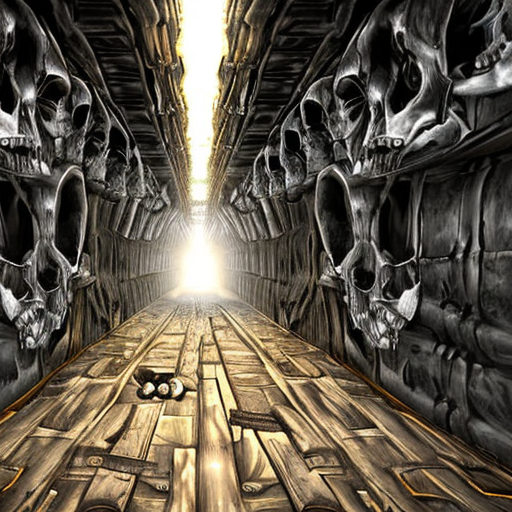

In [117]:
# find a good init image:

orig_prompt = "tunnel made of skulls and skeletons, trending on artstation, 4k"
orig_negative_prompt = "frame, ugly, low quality"

num_images = 1
seed = 212
num_inference_steps = 20
guidance_scale = 8
height = 512
width = height


prompt = [orig_prompt] * num_images
negative_prompt = [orig_negative_prompt] * num_images

current_image = PIL.Image.new(mode="RGBA", size=(height, width))
mask_image = np.array(current_image)[:,:,3] 
mask_image = Image.fromarray(255-mask_image).convert("RGB")
current_image = current_image.convert("RGB")

images = pipe(prompt=prompt,
              negative_prompt=negative_prompt,
              image=current_image,
              guidance_scale = guidance_scale,
              height = height,
              width = width, 
              generator = g_cuda.manual_seed(seed),
              mask_image=mask_image, 
              num_inference_steps=num_inference_steps)[0]


image_grid(images, rows=1, cols=num_images)

In [106]:
prompt = ["stars in the dark sky"]
current_image = images[0]

NUMFRAMES = 3

all_frames = []
all_frames.append(current_image)

for i in range(NUMFRAMES):
  print('Generating image: ' + str(i+1) + ' / ' + str(NUMFRAMES))

  #create random mask image
  current_image = current_image.convert('RGBA')
  mask_image = np.array(current_image)[:,:,3] 
  m = np.random.randint(0,2,size=mask_image.shape).astype(np.bool)
  r = np.zeros(mask_image.shape)
  mask_image[m] = r[m]
  mask_image = Image.fromarray(mask_image).convert("RGB")
  current_image = current_image.convert("RGB")

  #inpaint
  
  images = pipe(prompt=prompt,
                negative_prompt=negative_prompt,
                image=current_image,
                guidance_scale = guidance_scale,
                height = height,
                width = width, 
                #generator = g_cuda.manual_seed(seed),
                mask_image=mask_image, 
                num_inference_steps=num_inference_steps)[0]
  current_image = images[0]

  all_frames.append(current_image)
  clear_output(wait=True)

Generating image: 3 / 3


  0%|          | 0/20 [00:00<?, ?it/s]

In [118]:
current_image = images[0]

STEPSIZE = 2**5
NUMFRAMES = 100

all_frames = []
all_frames.append(current_image)

for i in range(NUMFRAMES):
  print('Generating image: ' + str(i+1) + ' / ' + str(NUMFRAMES))

  #shrink down by STEPSIZE
  prev_image = current_image.resize((height-2*STEPSIZE,width-2*STEPSIZE))
  prev_image = prev_image.convert("RGBA")
  prev_image = np.array(prev_image)

  #create blank non-transparent image
  blank_image = np.array(current_image.convert("RGBA"))*0
  blank_image[:,:,3] = 1

  #paste shrinked onto blank
  blank_image[STEPSIZE:height-STEPSIZE,STEPSIZE:width-STEPSIZE,:] = prev_image
  prev_image = Image.fromarray(blank_image)
  current_image = prev_image

  #create mask (black image with white STEPSIZE width edges)
  mask_image = np.array(current_image)[:,:,3] 
  mask_image = Image.fromarray(255-mask_image).convert("RGB")

  #inpaint
  current_image = current_image.convert("RGB")
  images = pipe(prompt=prompt,
                negative_prompt=negative_prompt,
                image=current_image,
                guidance_scale = guidance_scale,
                height = height,
                width = width, 
                #generator = g_cuda.manual_seed(seed),
                mask_image=mask_image, 
                num_inference_steps=num_inference_steps)[0]
  current_image = images[0]
  
  current_image.paste(prev_image, mask=prev_image)
  all_frames.append(current_image)
  clear_output(wait=True)

Generating image: 100 / 100


  0%|          | 0/20 [00:00<?, ?it/s]

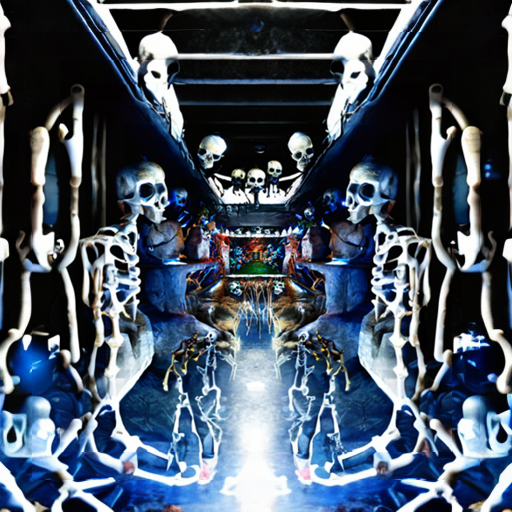

In [119]:
#check the 1st image of the video
current_image

In [120]:
write_video("infinite_zoom_out.mp4", all_frames, 16)

In [ ]:
#frame_one = all_frames[0]
#frame_one.save("all_frames.gif", format="GIF", append_images=all_frames[1:], save_all=True, duration=250, loop=0)